# Carrot Detector

**In this notebook I will be using Convolution Neural Network to classify images as carrots or apples.**

## Dataset
This data was sourced from Kaggle: [**Fruits and Vegetables Image Recognition Dataset**](https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition)

To save on time and resources, I am only using *carrots* and *apples* images from the dataset.

### About the data:
- Train: contains 100 images per category
- Test: contains 10 images per category
- Validation: contains 10 images per category

### References: 
To build this notebook, I used a variety of resources:
- Inspiration for classification was taken from this [Kaggle Notebook](https://www.kaggle.com/code/abdelrahman16/fruit-and-vegetable-classification/notebook)
- UBC MDS lecture and lab notes 
- ChatGPT to modify, update or debug the code


## Loading and Transforming

In [1]:
# imports
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pathlib import Path

In [2]:
# determine paths
data_dir = Path("../data")
train_dir = data_dir / "train"
val_dir = data_dir / "validation"
test_dir = data_dir / "test"

# image size
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 32

# transforms for preprocessing
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),          # Resize to 64x64
    transforms.ToTensor(),                  # Convert to tensor
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
])

# create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# and dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# check class labels 
print("Classes:", train_dataset.classes)

Classes: ['apple', 'carrot']


*Now that we can confirm that our images are loaded appropriately, let's start creating a simple convolutional neural network (CNN) architecture to classify whether an image is a "Carrot" or "Apple".*

In [3]:
# first, we will build our classifier
class CarrotAppleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(5, 5)),  # RGB input -> 16 channels
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),

            nn.Conv2d(16, 32, kernel_size=(5, 5)),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),

            nn.Conv2d(32, 32, kernel_size=(3, 3)),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(32 * 11 * 11, 128),  # adjusted based on summary output
            nn.ReLU(),
            nn.Linear(128, 1)  # output 1 value for binary classification
        )

    def forward(self, x):
        return self.main(x)

In [4]:
# let's look at the summary 

# instantiate model
model = CarrotAppleClassifier()

# move model to the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# summary -- input shape is (channels, height, width) 
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 60, 60]           1,216
              ReLU-2           [-1, 16, 60, 60]               0
         MaxPool2d-3           [-1, 16, 30, 30]               0
           Dropout-4           [-1, 16, 30, 30]               0
            Conv2d-5           [-1, 32, 26, 26]          12,832
              ReLU-6           [-1, 32, 26, 26]               0
         MaxPool2d-7           [-1, 32, 13, 13]               0
           Dropout-8           [-1, 32, 13, 13]               0
            Conv2d-9           [-1, 32, 11, 11]           9,248
             ReLU-10           [-1, 32, 11, 11]               0
          Flatten-11                 [-1, 3872]               0
           Linear-12                  [-1, 128]         495,744
             ReLU-13                  [-1, 128]               0
           Linear-14                   

*To summarize above, the model:*
- Takes RGB images (64×64) 
- Extracts features through 3 convolutional blocks with ReLU + pooling + dropout 
- Flattens the feature map and feeds it through 2 fully connected layers 
- Outputs 1 value (logit), which is converted to a probability via sigmoid for binary classification (Carrot vs Apple)

In [5]:
# now we will create a training loop
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, patience=2, verbose=True):
    train_loss, valid_loss, train_accuracy, valid_accuracy = [], [], [], []
    consec_increases = 0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_acc = 0.0

        for X, y in trainloader:
            optimizer.zero_grad()
            y_hat = model(X).squeeze()
            loss = criterion(y_hat, y.float())  # BCE expects float targets
            loss.backward()
            optimizer.step()

            preds = (torch.sigmoid(y_hat) > 0.5).float()
            acc = (preds == y).float().mean()

            running_loss += loss.item()
            running_acc += acc.item()

        train_loss.append(running_loss / len(trainloader))
        train_accuracy.append(running_acc / len(trainloader))

        # Validation
        model.eval()
        val_loss, val_acc = 0.0, 0.0
        with torch.no_grad():
            for X, y in validloader:
                y_hat = model(X).squeeze()
                loss = criterion(y_hat, y.float())
                preds = (torch.sigmoid(y_hat) > 0.5).float()
                acc = (preds == y).float().mean()

                val_loss += loss.item()
                val_acc += acc.item()

        valid_loss.append(val_loss / len(validloader))
        valid_accuracy.append(val_acc / len(validloader))

        if verbose:
            print(f"Epoch {epoch + 1}: "
                  f"Train Loss: {train_loss[-1]:.3f}, Train Acc: {train_accuracy[-1]:.2f}, "
                  f"Val Loss: {valid_loss[-1]:.3f}, Val Acc: {valid_accuracy[-1]:.2f}")

        # Early stopping check
        if epoch > 0 and valid_loss[-1] > valid_loss[-2]:
            consec_increases += 1
        else:
            consec_increases = 0
        if consec_increases >= patience:
            print("Early stopping triggered.")
            break

    return {
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "valid_loss": valid_loss,
        "valid_accuracy": valid_accuracy
    }


In [6]:
# now let's train the model
# Model and device
model = CarrotAppleClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move data to device inside training loop
results = trainer(model, criterion, optimizer, train_loader, val_loader, epochs=10)

/Users/ashitadiwan/miniforge3/envs/carrot-detector/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1: Train Loss: 0.697, Train Acc: 0.47, Val Loss: 0.677, Val Acc: 0.47
Epoch 2: Train Loss: 0.650, Train Acc: 0.54, Val Loss: 0.594, Val Acc: 0.84
Epoch 3: Train Loss: 0.573, Train Acc: 0.77, Val Loss: 0.446, Val Acc: 0.89
Epoch 4: Train Loss: 0.481, Train Acc: 0.80, Val Loss: 0.350, Val Acc: 0.89
Epoch 5: Train Loss: 0.418, Train Acc: 0.83, Val Loss: 0.290, Val Acc: 0.89
Epoch 6: Train Loss: 0.326, Train Acc: 0.86, Val Loss: 0.257, Val Acc: 0.89
Epoch 7: Train Loss: 0.273, Train Acc: 0.89, Val Loss: 0.247, Val Acc: 0.89
Epoch 8: Train Loss: 0.259, Train Acc: 0.90, Val Loss: 0.187, Val Acc: 0.95
Epoch 9: Train Loss: 0.224, Train Acc: 0.91, Val Loss: 0.150, Val Acc: 0.95
Epoch 10: Train Loss: 0.164, Train Acc: 0.96, Val Loss: 0.233, Val Acc: 0.95


*It seems like the model is achieving a high validation accuracy of 95%. This is a good sign that the model is well-trained.* 

*It is important to note that this model is trained on a small dataset.*

*Let's visualize it with images below*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].


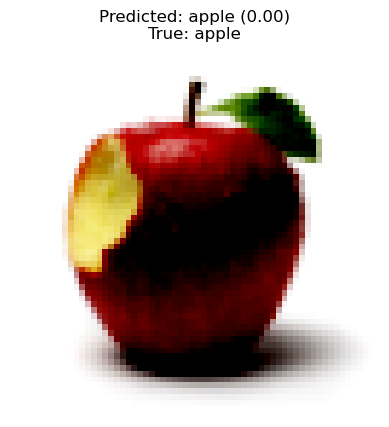

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].


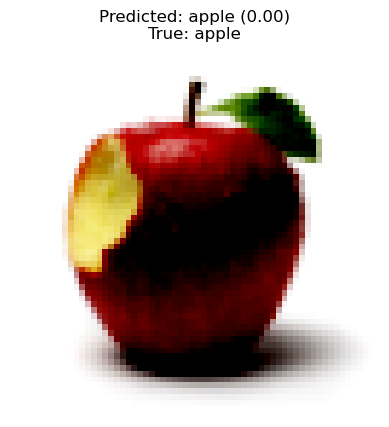

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


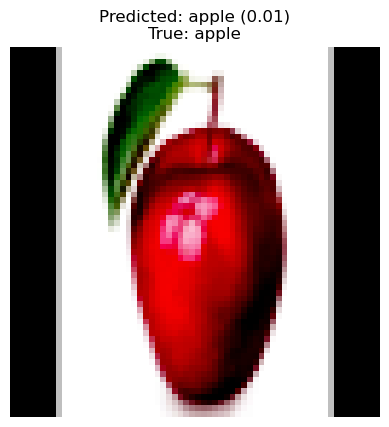

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.9607843].


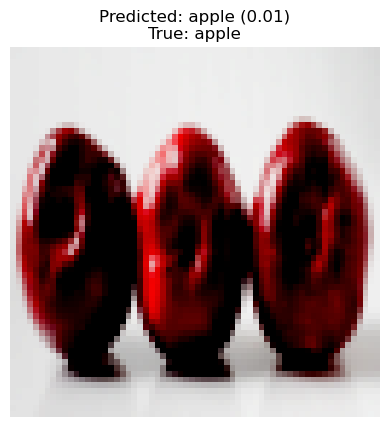

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.9372549].


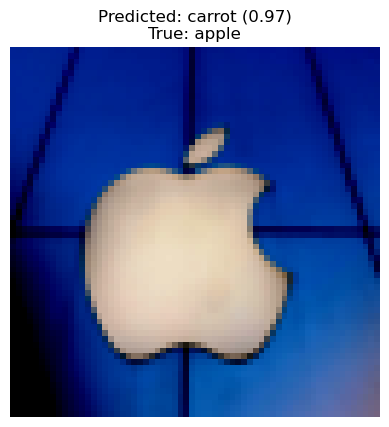

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


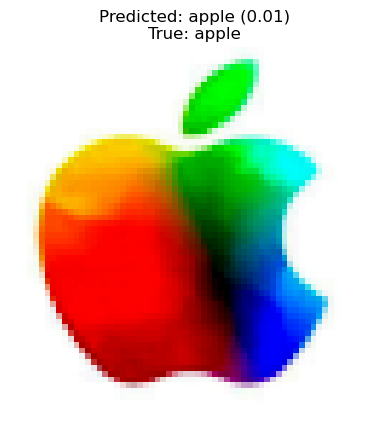

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].


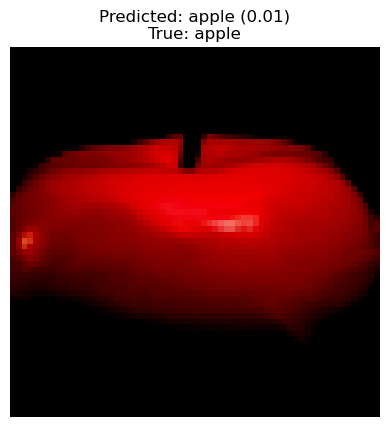

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].


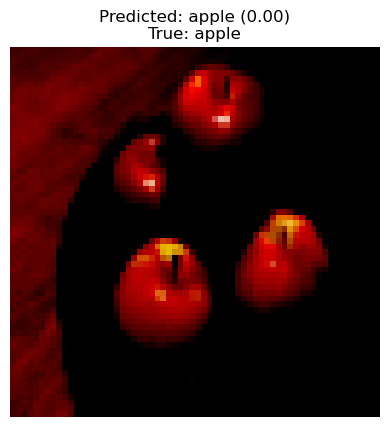

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].


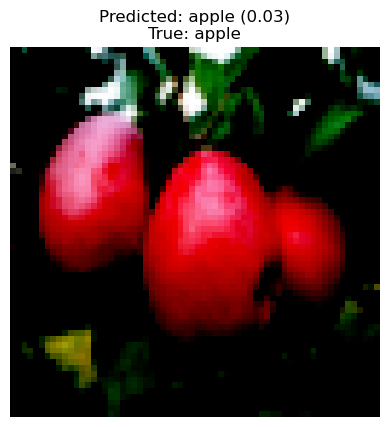

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..1.0].


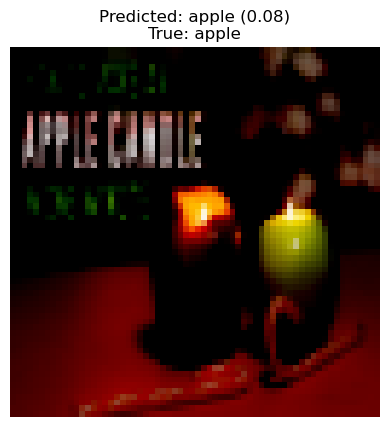

In [7]:
model.eval()
model.to("cpu")

# Get one batch from validation loader
with torch.no_grad():
    imgs, labels = next(iter(val_loader))

    for i in range(min(10, len(imgs))):  # show up to 10 images
        img = imgs[i]
        true_label = labels[i].item()
        y_prob = torch.sigmoid(model(img[None])).item()
        y_class = int(y_prob > 0.5)

        plt.imshow(img.permute(1, 2, 0))
        plt.title(f"Predicted: {train_dataset.classes[y_class]} ({y_prob:.2f})\n"
                  f"True: {train_dataset.classes[true_label]}")
        plt.axis("off")
        plt.show()